In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
from so_noise_models.so_models_v3 import SO_Noise_Calculator_Public_v3_1_2 as so_models
from itertools import combinations_with_replacement as cwr

from copy import deepcopy
import astropy.units as u
# from astropy.cosmology import Planck18 as P18

In [2]:
import inspect
class_module_path = inspect.getfile(Class)
print("Class module is imported from:", class_module_path)

Class module is imported from: /Users/Viv/Library/Python/3.11/lib/python/site-packages/classy-3.2.1-py3.11-macosx-13-x86_64.egg/classy.cpython-311-darwin.so


## SO Noise Models
Load in the noise curves from the code, double check that we've got the right theory basis and can calculate separately from code.

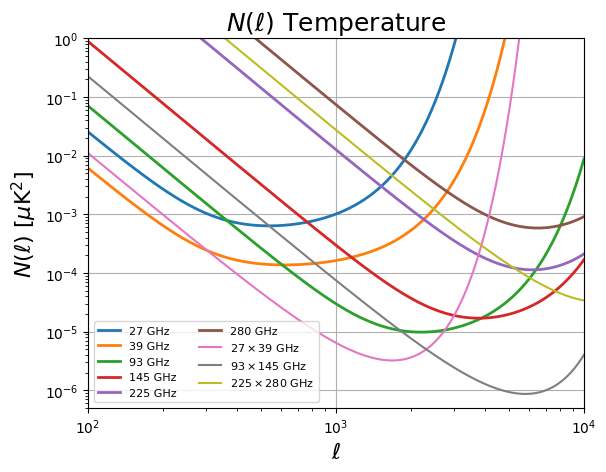

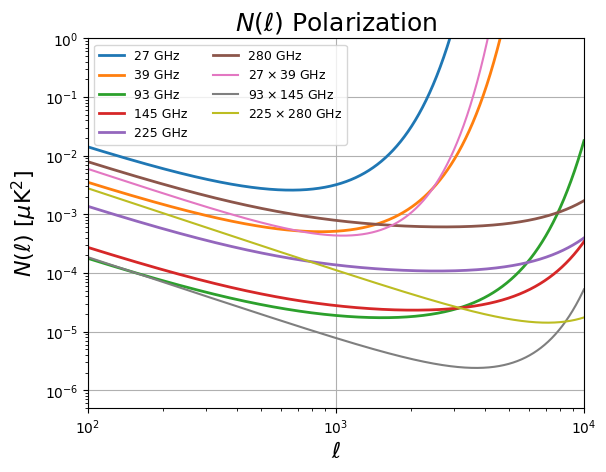

In [4]:
# mode = 0 is for threshold, mode = 1 is for baseline, mode = 2 is for goal
mode=1
fsky=0.4
ellmax=1e4
el=50.

lat = so_models.SOLatV3point1(mode, el=el)
corr_pairs = [(0,1),(2,3),(4,5)]

bands = lat.get_bands()
N_bands = len(bands)

ell, N_ell_LA_T_full,N_ell_LA_P_full = lat.get_noise_curves(
    fsky, ellmax, 1, full_covar=True, deconv_beam=True)

WN_levels = lat.get_white_noise(fsky)**.5

N_ell_LA_T  = N_ell_LA_T_full[range(N_bands),range(N_bands)]
N_ell_LA_Tx = [N_ell_LA_T_full[i,j] for i,j in corr_pairs]
N_ell_LA_P  = N_ell_LA_P_full[range(N_bands),range(N_bands)]
N_ell_LA_Px = [N_ell_LA_P_full[i,j] for i,j in corr_pairs]

def plot_temperature_noise_curves():
    ## plot the temperature noise curves
    plt.figure()
    for i in range(N_bands):
        plt.loglog(ell,N_ell_LA_T[i], label='%i GHz' % (bands[i]), ls='-', lw=2.)
    for _c,(i,j) in enumerate(corr_pairs):
        plt.loglog(ell, N_ell_LA_T_full[i,j],
                label=r'$%i \times %i$ GHz' % (bands[i],bands[j]), lw=1.5)

    plt.title(r"$N(\ell$) Temperature", fontsize=18)
    plt.ylabel(r"$N(\ell$) [$\mu$K${}^2$]", fontsize=16)
    plt.xlabel(r"$\ell$", fontsize=16)
    plt.ylim(5e-7,1e0)
    plt.xlim(100,10000)
    plt.legend(loc='lower left', ncol=2, fontsize=8)
    plt.grid()

def plot_polarization_noise_curves():
    ## plot the polarization noise curves
    plt.figure()
    for i in range(N_bands):
        plt.loglog(ell,N_ell_LA_P[i], label='%i GHz' % (bands[i]), ls='-', lw=2.)
    for _c,(i,j) in enumerate(corr_pairs):
        plt.loglog(ell, N_ell_LA_P_full[i,j],
                label=r'$%i \times %i$ GHz' % (bands[i],bands[j]), lw=1.5)

    plt.title(r"$N(\ell$) Polarization", fontsize=18)
    plt.ylabel(r"$N(\ell$) [$\mu$K${}^2$]", fontsize=16)
    plt.xlabel(r"$\ell$", fontsize=16)
    plt.ylim(5e-7,1e0)
    plt.xlim(100,10000)
    plt.legend(loc='upper left', ncol=2, fontsize=9)
    plt.grid()

plot_temperature_noise_curves()
plot_polarization_noise_curves()

In [5]:
def noise_curve_93GHz_baseline(ell):

    arcmin = 0.000291 # rad
    Delta_T = 8.0*u.uK*arcmin
    theta_FWHM = 2.2*arcmin
    Nred = 1800*u.uK**2*u.s
    fsky = 0.4
    ell_knee = 1000
    alpha_knee = -3.5

    Nwhite = Delta_T.value**2*np.exp( ell*(ell+1)*theta_FWHM**2/(8*np.log(2)) ) # unit is uK^2
    
    Natm = (Nred*(4*np.pi*fsky)/(157680000*u.s*0.2*0.85) ).value # unit is uK^2
    Natm *= (ell/ell_knee)**alpha_knee
    Natm *= np.exp(ell*(ell+1)*theta_FWHM**2/(8*np.log(2)))

    Nell = Nwhite + Natm

    return np.array(Nell)

def noise_curve_93GHz_goal(ell):

    arcmin = 0.000291 # rad
    Delta_T = 5.8*u.uK*arcmin
    theta_FWHM = 2.2*arcmin
    Nred = 1800*u.uK**2*u.s
    fsky = 0.4
    ell_knee = 1000
    alpha_knee = -3.5

    Nwhite = Delta_T.value**2*np.exp( ell*(ell+1)*theta_FWHM**2/(8*np.log(2)) ) # unit is uK^2
    
    Natm = (Nred*(4*np.pi*fsky)/(157680000*u.s*0.2*0.85) ).value # unit is uK^2
    Natm *= (ell/ell_knee)**alpha_knee
    Natm *= np.exp(ell*(ell+1)*theta_FWHM**2/(8*np.log(2)))

    Nell = Nwhite + Natm

    return np.array(Nell)

def noise_curve_93GHz_test(ell):

    arcmin = 0.000291 # rad
    Delta_T = 8.0*u.uK*arcmin
    theta_FWHM = 2.2*arcmin
    # Nred = 1800*u.uK**2*u.s 
    Nred = 230/2*u.uK**2*u.s #factor of 2 is for FOV modification?
    fsky = 0.4
    ell_knee = 1000
    alpha_knee = -3.5

    Nwhite = Delta_T.value**2*np.exp( ell*(ell+1)*theta_FWHM**2/(8*np.log(2)) ) # unit is uK^2
    
    Natm = (Nred*(4*np.pi*fsky)/(157680000*u.s*0.2*0.85) ).value # unit is uK^2
    Natm *= (ell/ell_knee)**alpha_knee
    Natm *= np.exp(ell*(ell+1)*theta_FWHM**2/(8*np.log(2)))

    Nell = Nwhite + Natm

    return np.array(Nell)*u.uK**2

Text(1.5, 1e-05, '$\\nu=93$ GHz')

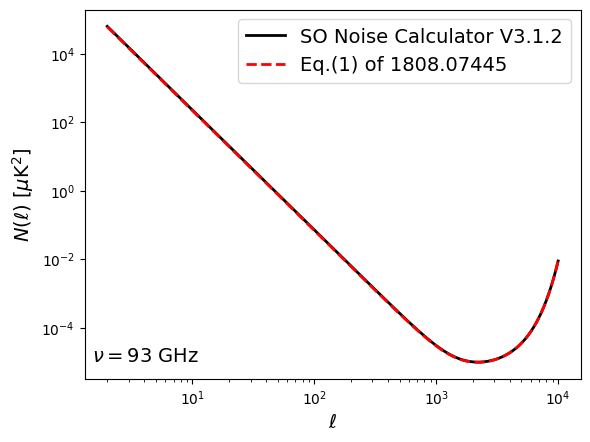

In [6]:
plt.loglog(ell,N_ell_LA_T[2], label='SO Noise Calculator V3.1.2',
               color='k', ls='-', lw=2.)
# plt.loglog(ell, noise_curve_93GHz_baseline(ell), label='Baseline noise', color='gray', ls='-', lw=2.)
# plt.loglog(ell, noise_curve_93GHz_goal(ell), label='Goal noise', color='k', ls='-', lw=2.)
plt.loglog(ell, noise_curve_93GHz_test(ell), label='Eq.(1) of 1808.07445', color='red', ls='--', lw=2.)
plt.ylabel(r"$N(\ell$) [$\mu$K${}^2$]", fontsize=14)
plt.xlabel(r"$\ell$", fontsize=14)
plt.legend(fontsize=14)
plt.text(1.5e0, 0.1e-4, r'$\nu=93$ GHz', fontsize=14)

## Add in Planck noise

Following Sec. 2.5 in 1808.07445.

In [7]:
frequencies = {
    "LAT": ["27", "39", "93", "145", "225", "280"],
    "Planck": ["100", "143", "217", "353"]
}

f_pairs_LAT = ["LAT_27xLAT_27",
               "LAT_39xLAT_39",
               "LAT_93xLAT_93",
               "LAT_145xLAT_145",
               "LAT_225xLAT_225",
               "LAT_280xLAT_280",
               "LAT_27xLAT_39",
               "LAT_93xLAT_145",
               "LAT_225xLAT_280"]

f_pairs_Planck = ["Planck_{}xPlanck_{}".format(*cross) for cross in cwr(frequencies["Planck"], 2)]

Generate SO Noise Curves

In [8]:
N_ell_T = {"LAT_{}xLAT_{}".format(*cross): ell * 0. for cross in cwr(frequencies["LAT"], 2)}
N_ell_P = deepcopy(N_ell_T)

In [9]:
N_ell_T_list = np.concatenate([N_ell_LA_T, N_ell_LA_Tx])
N_ell_P_list = np.concatenate([N_ell_LA_P, N_ell_LA_Px])

for i, f_pair in enumerate(f_pairs_LAT):
  N_ell_T[f_pair] = N_ell_T_list[i]
  N_ell_P[f_pair] = N_ell_P_list[i]

Planck noise described in 1807.06206, and 1807.06207. Code inspired by https://github.com/simonsobs/PSpipe/blob/master/notebooks/tutorial_maps2params.ipynb.

In [10]:
sigma = {"Planck_{}xPlanck_{}".format(*cross): 0. for cross in cwr(frequencies["Planck"], 2)}
sigma_pol = deepcopy(sigma)

# converted temperature noise level from Table 4 of 1807.06205 to micro-Kelvin*arcmin
sigma["Planck_100xPlanck_100"] = 77.4
sigma["Planck_143xPlanck_143"] = 33.0
sigma["Planck_217xPlanck_217"] = 46.80
sigma["Planck_353xPlanck_353"] = 153.6

# converted polarization noise level from Table 4 of 1807.06205 to micro-Kelvin*arcmin
sigma_pol["Planck_100xPlanck_100"] = 117.6
sigma_pol["Planck_143xPlanck_143"] = 70.2
sigma_pol["Planck_217xPlanck_217"] = 105.0
sigma_pol["Planck_353xPlanck_353"] = 438.6

for f_pair in f_pairs_Planck:
    sigma_rad = np.deg2rad(sigma[f_pair]) / 60
    N_ell_T[f_pair] = ell * 0 + sigma_rad**2
    sigma_pol_rad = np.deg2rad(sigma_pol[f_pair]) / 60
    N_ell_P[f_pair] = ell * 0 + sigma_pol_rad**2

Generation of beam harmonics

Finally let's generate the beam harmonic transform for Planck and SO LAT. For Planck we will use
information from the Table 4 of [https://arxiv.org/pdf/1807.06205.pdf](https://arxiv.org/pdf/1807.06205.pdf). For SO we use info from Table
1 of [https://arxiv.org/pdf/1808.07445.pdf](https://arxiv.org/pdf/1808.07445.pdf)

In [11]:
# all in units of arcmin

beam_fwhm = {}
beam_fwhm["LAT_27"] = 7.4
beam_fwhm["LAT_39"] = 5.1
beam_fwhm["LAT_93"] = 2.2
beam_fwhm["LAT_145"] = 1.4
beam_fwhm["LAT_225"] = 1.0
beam_fwhm["LAT_280"] = 0.9

beam_fwhm["Planck_100"] = 9.68
beam_fwhm["Planck_143"] = 7.30
beam_fwhm["Planck_217"] = 5.02
beam_fwhm["Planck_353"] = 4.94

### Component Separated Noise from so_noise_models

In [23]:
class_params = {
        'output':'tCl,lCl,pCl',
        # 'theta_s_100': pars_dict['theta_s_100'],
        'H0':  67.36,
        'omega_b': 0.02237,   
        'omega_cdm': 0.1200,  
        'A_s': 2.100e-9,
        'n_s': 0.9649,
        'tau_reio': 0.0544,
        'N_eff': 3.046,
        'YHe':'BBN',
        'l_max_scalars':5000,
        'lensing':'yes',
        'gauge':'synchronous'}

M = Class()
M.set(class_params)
M.compute()

ell_max = class_params['l_max_scalars']

ell = M.lensed_cl(ell_max)['ell'][2:]
Cl_tt = M.lensed_cl(ell_max)['tt'][2:]*(M.T_cmb()*1e6)**2
Cl_te = M.lensed_cl(ell_max)['te'][2:]*(M.T_cmb()*1e6)**2
Cl_ee = M.lensed_cl(ell_max)['ee'][2:]*(M.T_cmb()*1e6)**2

In [24]:
comp_ell, Deproj0, Deproj1, Deproj2, Deproj3  = np.loadtxt('so_noise_models/LAT_comp_sep_noise/v3.1.0/SO_LAT_Nell_T_atmv1_baseline_fsky0p4_ILC_CMB.txt').T
comp_ell_goal, Deproj0_goal, Deproj1_goal, Deproj2_goal, Deproj3_goal  = np.loadtxt('so_noise_models/LAT_comp_sep_noise/v3.1.0/SO_LAT_Nell_T_atmv1_goal_fsky0p4_ILC_CMB.txt').T

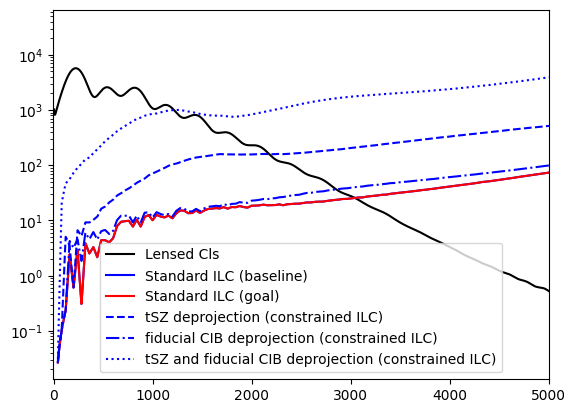

In [26]:
plt.semilogy(ell, ell*(ell+1)*Cl_tt/(2*np.pi), label='Lensed Cls', color='black')
plt.semilogy(comp_ell, comp_ell*(comp_ell+1)*Deproj0/(2*np.pi), label='Standard ILC (baseline)', color='blue')
plt.semilogy(comp_ell, comp_ell*(comp_ell+1)*Deproj0/(2*np.pi), label='Standard ILC (goal)', color='red')
plt.semilogy(comp_ell, comp_ell*(comp_ell+1)*Deproj1/(2*np.pi), label='tSZ deprojection (constrained ILC)',color='blue',ls='--')
plt.semilogy(comp_ell, comp_ell*(comp_ell+1)*Deproj2/(2*np.pi), label='fiducial CIB deprojection (constrained ILC)',color='blue',ls='-.')
plt.semilogy(comp_ell, comp_ell*(comp_ell+1)*Deproj3/(2*np.pi), label='tSZ and fiducial CIB deprojection (constrained ILC)',color='blue',ls=':')

plt.xlim(-10,5000)
plt.legend()